# A first classifier in pytorch : language identification using a bag of word input  

Copy this notebook (File>Save a copy in Drive)

Add your **name** in the copied notebook's name

When you're done, send me an email with subject "ML1 pytorch bowclassifier + last NAME + first name", with the link with **EDITION** rights (before **Wednesday Nov 29, midnight**!)

The basic way of creating a neural network in Pytorch is to define a class inheriting from the nn.Module.

The steps are:
- define a class inheriting from the nn.Module, which should contain at least declarations (members) for all that will be parameters of the network (=to be learnt)
- define a forward method
- you don't have to define the backpropagation method ! given the forward method, pytorch automatically and dynamically builds the computation graphs and computes gradients when necessary
- pytorch also allows you to easily switch the computing device : from CPU to GPU

**NB** all forward propagations in nn.Module and subclasses take as input a (mini-)batch of input vectors, and not a single vector. Remember the first axis (axis 0) is **always** for the batch.


In [92]:
# modified version of notebook by Robert Guthrie
# https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # for the optimizers (SDG, Adam ...)

from random import shuffle

torch.manual_seed(1)

Creating a MLP for language identification in PyTorch
======================================







## Defining the network

The objective is to build a classifier for language identification (input = sequence, output=its language), representing the input as a BOW vector.

We will build a MLP with a single hidden layer with a non-linear activation function, and softmax to get probabilities of classes.
We'll then use the negative log likelihood loss, and stochastic gradient descent to learn the parameters.

Because log-likelihood supposes to take the log of probabilities, in our network we will directly output log-softmax instead of softmax.



In [93]:
class MyMLP(nn.Module):  # inheriting from nn.Module

    def __init__(self, nb_classes, d, hidden_layer_size):
        """ - d is the size of the vectors representing the objects to classify
            - hidden_layer_size is ... the size of the hidden layer
        """
        # calls the init function of the superclass, i.e. nn.Module
        super(MyMLP, self).__init__()

        # The parameters of the network that must be learnt
        # are inferred thanks to pytorch machinary,
        # from what is declared in the constructor

        # linear layer Wx + b
        # => implicitely contains parameters W and b
        # cf. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # which are randomly initialized by default
        self.linear_1 = nn.Linear(d, hidden_layer_size)

        # another pair of W and b parameters
        self.linear_2 = nn.Linear(hidden_layer_size, nb_classes)

        # NB: the non-linear activation functions do not have any parameter
        # so we don't need to declare it in the __init__ method
        # they will be used directly in the forward method

    def forward(self, X):
        """
        Input : X batch of inputs : ( shape (b, d) )
                with b is the size of the batch (it does not have to be constant)
        Output : log probabilities (shape (b, nb_classes) )
        """
        # linear combination from input to hidden layer
        out = self.linear_1(X) # out shape (b, hidden_layer_size)

        # activation function at hidden layer
        out = torch.relu(out) # same shape

        # linear combination from hidden to output layer
        out = self.linear_2(out) # out shape (b, nb_classes)

        # Transformation into log-probabilities
        #  Note : Since we're going to use the NLL loss,
        #         we will need to apply log to softmax anyway
        #         we do it here because directly computing log of softmax is numerically more stable
        # CAUTION: the dim=1 is crucial here to tell pytorch on which axis apply the softmax
        return F.log_softmax(out, dim=1) # out shape (b, nb_classes)

# examples
my_classifier = MyMLP(nb_classes=3, d=20, hidden_layer_size=10)

# nn.Module and any subclass (e.g. nn.Linear, BoWClassifier)
# records what are the parameters
# depending on what has been declared in the __init__ method.

# For nn.Linear, the first param is matrix W, the second is bias b.
# Through some Python magic from the PyTorch devs, your module
# (in this case, BoWClassifier) will store knowledge of the nn.Linear's parameters

# and the parameters have requires_grad set to True of course
for name, param in my_classifier.named_parameters():
    print("PARAM named %s, of shape %s" % (name, str(param.shape)))
    print(param)





PARAM named linear_1.weight, of shape torch.Size([10, 20])
Parameter containing:
tensor([[ 0.1152, -0.0987, -0.0433,  0.1050, -0.2105,  0.1341, -0.0460,  0.1138,
          0.0311, -0.0274,  0.0620,  0.0110,  0.0817, -0.0871, -0.0163, -0.0201,
          0.0324, -0.0009,  0.1955,  0.0696],
        [-0.0833, -0.1350, -0.0375, -0.0965, -0.0717,  0.0107,  0.1333,  0.1215,
         -0.2186,  0.1386,  0.0625,  0.2121,  0.1476, -0.2037, -0.2126, -0.1079,
          0.1964, -0.0372,  0.0957, -0.1039],
        [ 0.2194, -0.0946,  0.1677,  0.0026, -0.1178,  0.1149, -0.1187,  0.0658,
         -0.0646, -0.0245, -0.2150, -0.1066,  0.1213, -0.0544,  0.2227,  0.1792,
         -0.0105, -0.1493,  0.1362,  0.0694],
        [-0.1445,  0.1452,  0.1358,  0.1983, -0.1253, -0.0368, -0.0043,  0.0327,
         -0.1697, -0.1587,  0.1216, -0.0524,  0.1092,  0.0127,  0.0734,  0.0492,
          0.0813,  0.1108, -0.2071,  0.1126],
        [-0.1572, -0.1687,  0.0136, -0.0381,  0.1313, -0.1295, -0.1988,  0.1627,
      

## Toy dataset for language identification

The task we consider is **language identification**,
and we are using a toy data set of 4 training examples, and 2 test examples (below).



In [94]:
train_examples = [("me gusta comer en la cafeteria".split(), "SPANISH"),
                  ("Give it to me".split(), "ENGLISH"),
                  ("No creo que sea una buena idea".split(), "SPANISH"),
                  ("No it is not a good idea to get lost at sea".split(), "ENGLISH")]

test_examples = [("Yo creo que si".split(), "SPANISH"),
                 ("it is lost on me".split(), "ENGLISH")]



In [95]:
train_examples[1]

(['Give', 'it', 'to', 'me'], 'ENGLISH')


## TODO 1: Encoding data : creating indices and converting data to tensors

**NB**: you can implement it yourself or use the CountVectorizer of sklearn.

**NB**: if you use the CountVectorizer, you need to convert the obtained numpy sparse matrix into torch Tensor: if A is the numpy matrix, use `torch.from_numpy(A).float()`

In [96]:
# word to index
# and label to index correspondances
w2i = {}
i2w = []
label2i = {}
i2label = []


# TODO:

# fill in the w2i, i2w, label2i and i2label
# using the training examples only
# the words in test that are unknown in train will be ignored

labels = set()
vocab = set()

for example in train_examples:
  for token in example[0]:
    vocab.add(token.lower())

w2i = {word : index for index,word in enumerate(vocab)}
i2w = list(vocab)

for example in train_examples:
  labels.add(example[1])

label2i = {label : index for index,label in enumerate(labels)}
i2label = list(labels)


# instead YOU CAN USE the CountVectorizer of sklearn


VOCAB_SIZE = len(w2i)
NB_CLASSES = len(label2i)

print("VOCAB SIZE:", VOCAB_SIZE)
print("NB CLASSES:", NB_CLASSES)
print("w2i:", w2i)
print("i2w:", i2w)

print("label2i:", label2i)

def convert_examples_to_tensors(examples, w2i, label2i):
    """ Input =
          - list of n examples
             -- each example is a pair [sentence, class label]
             -- a sentence being a list of tokens
          - dictionary of words to indices
          - dictionary of class labels to indices
        Output =
          - X = BOW vectors for the n examples:
              = pytorch tensor of shape ( n , vocabulary size )
                X[i, j] = number of occ of word j in sentence i
          - Y = tensor of shape  ( n ) for indices of gold labels
    """
    # separating input sentences and gold labels
    (sentences, gold_labels) = list(zip(*examples))
    n = len(examples)
    # TODO
    X = torch.zeros(n,len(w2i))
    Y = []
    #print(X.size())

    # Vectorizing the examples using Tensor
    for i in range(len(sentences)):
      for word in sentences[i]:
        index = w2i.get(word.lower())
        if index:
          X[i,index]=X[i,index]+1

    # Vectorizing the Labels
    Y = torch.LongTensor([label2i[gold_label] for gold_label in gold_labels])


    return X, Y



X_test = None
X_train = None
Y_test = None
Y_train = None

X_train, Y_train = convert_examples_to_tensors(train_examples, w2i, label2i)
X_test, Y_test = convert_examples_to_tensors(test_examples, w2i, label2i)

print("X_test", X_test)
print("Y_test", Y_test)


VOCAB SIZE: 23
NB CLASSES: 2
w2i: {'is': 0, 'it': 1, 'cafeteria': 2, 'not': 3, 'comer': 4, 'at': 5, 'no': 6, 'to': 7, 'gusta': 8, 'me': 9, 'una': 10, 'creo': 11, 'idea': 12, 'get': 13, 'sea': 14, 'good': 15, 'buena': 16, 'que': 17, 'a': 18, 'lost': 19, 'en': 20, 'la': 21, 'give': 22}
i2w: ['is', 'it', 'cafeteria', 'not', 'comer', 'at', 'no', 'to', 'gusta', 'me', 'una', 'creo', 'idea', 'get', 'sea', 'good', 'buena', 'que', 'a', 'lost', 'en', 'la', 'give']
label2i: {'ENGLISH': 0, 'SPANISH': 1}
X_test tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0.]])
Y_test tensor([1, 0])


In [97]:
my_classifier = MyMLP(nb_classes=NB_CLASSES, d=VOCAB_SIZE, hidden_layer_size=10)

## Test of forward propagation (with random parameters)

In [98]:
# Test of forward propagation with the randomly initialized parameters:

with torch.no_grad():
    # X_test : shape [n , vocab_size]
    # NB: to run the forward method, use the name of the MyMLM instance
    log_probs = my_classifier(X_test)  # shape [n , num_labels]
    print("Log probabilities on test before training:\n", log_probs)

    # prediction : argmax of the log_probabilities
    # (make sure to control the axis on which the argmax is computed)
    pred_labels = torch.argmax(log_probs, dim=1) # shape n
    print("PREDICTED LABELS", [ i2label[l] for l in pred_labels ])
    print("     GOLD LABELS", [ i2label[l] for l in Y_test ])


Log probabilities on test before training:
 tensor([[-0.5636, -0.8421],
        [-0.7186, -0.6683]])
PREDICTED LABELS ['ENGLISH', 'SPANISH']
     GOLD LABELS ['SPANISH', 'ENGLISH']


## Training

So lets train! To do this, we pass instances through forward propagation
to get log probabilities, compute a loss function, compute the gradient of the loss
function, and then update the parameters with a gradient step.

Loss functions are provided by Torch in the nn package. nn.NLLLoss() is the
negative log likelihood loss we want.

Optimization functions are in torch.optim. Here, we will just use SGD.


In [99]:


# --------- the loss -------------
# negative log likelihood loss
# TODO: check its input and output https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
loss_function = nn.NLLLoss()

# --------- the optimizer --------
# simplest one: stochastic gradient descent
# we declare the parameters we wish to optimize
# => here we want to optimize all the parameters of our BoWClassifier instance
optimizer = optim.SGD(my_classifier.parameters(), lr=0.1)

print("\nTraining on:")
for x in train_examples:
    print(x)
print("\n")
print(label2i)


# loop on epochs
for epoch in range(30):
    print("Epoch", epoch)
    shuffle(train_examples) # NB: here original order is lost

    # NB: here if we had more examples,
    # we should loop on mini batches (in random order)
    # since we only have 4 training examples
    # on each epoch we use a full batch of 4 training examples

    # Step 1:
    # get tensors for batch of examples (here : one batch = all the training data)
    X, Y = convert_examples_to_tensors(train_examples, w2i, label2i)

    # Step 2:
    # (re)sets all parameter gradients to 0
    #  before using each batch of inputs
    my_classifier.zero_grad()

    # Step 3: forward propagation
    #         NB: my_classifier(X) implicitely calls my_classifier.forward(X)
    log_probs = my_classifier(X)
    print("LOG PROBS on train at epoch %i:\n" %epoch, log_probs)
    # optional: accuracy on this batch
    pred_labels = torch.argmax(log_probs, dim=1)
    print("PREDICTED LABELS ON BATCH", [ i2label[l] for l in pred_labels ])
    print("     GOLD LABELS ON BATCH", [ i2label[l] for l in Y ])

    # Step 4: Compute the loss (NB: this is the loss for the full batch of inputs X)
    #         The input to the loss function is for each example in X,
    #          the log_probabilities for each class, and the gold label
    loss = loss_function(log_probs,Y)


    # Step 5: Compute the gradients
    loss.backward() # partial derivatives of loss with respect to
                    # all the tensors that - were used to compute loss,
                    #                      - and have requires_grad=True
                    # after this call, all the parameters have their .grad attribute
                    # filled with the partial derivative

    # Step 6: Update the parameters
    #         NB: the optimizer instance knows what are the parameters to update
    optimizer.step()

# prediction after training:
print("\nPrediction on test, after training:")
# NB: when we are not training, we don't have to compute gradients
# => to be more efficient, we use torch.no_grad()
with torch.no_grad():
    log_probs = my_classifier(X_test)
    print("LOG PROBS on test:\n", log_probs)

    pred_labels = torch.argmax(log_probs, dim=1)
    print("PREDICTED LABELS", [ i2label[l] for l in pred_labels ])
    print("     GOLD LABELS", [ i2label[l] for l in Y_test ])




Training on:
(['me', 'gusta', 'comer', 'en', 'la', 'cafeteria'], 'SPANISH')
(['Give', 'it', 'to', 'me'], 'ENGLISH')
(['No', 'creo', 'que', 'sea', 'una', 'buena', 'idea'], 'SPANISH')
(['No', 'it', 'is', 'not', 'a', 'good', 'idea', 'to', 'get', 'lost', 'at', 'sea'], 'ENGLISH')


{'ENGLISH': 0, 'SPANISH': 1}
Epoch 0
LOG PROBS on train at epoch 0:
 tensor([[-0.5012, -0.9308],
        [-0.6770, -0.7095],
        [-0.6908, -0.6955],
        [-0.5435, -0.8692]], grad_fn=<LogSoftmaxBackward0>)
PREDICTED LABELS ON BATCH ['ENGLISH', 'ENGLISH', 'ENGLISH', 'ENGLISH']
     GOLD LABELS ON BATCH ['SPANISH', 'ENGLISH', 'ENGLISH', 'SPANISH']
Epoch 1
LOG PROBS on train at epoch 1:
 tensor([[-0.5706, -0.8329],
        [-0.6853, -0.7011],
        [-0.5423, -0.8709],
        [-0.6515, -0.7366]], grad_fn=<LogSoftmaxBackward0>)
PREDICTED LABELS ON BATCH ['ENGLISH', 'ENGLISH', 'ENGLISH', 'ENGLISH']
     GOLD LABELS ON BATCH ['SPANISH', 'ENGLISH', 'SPANISH', 'ENGLISH']
Epoch 2
LOG PROBS on train at epoch 2:
 

TODO 2
==

Copy the above training code and modify it to:
- implement the inner loop on batches (size of batch = hyperparameter)
- implement early stopping
- switch to the dataset below, containing a train/dev/set of Europarl sentences in French and English: test your code for learning on the train set / early stopping on dev / evaluating on the test set

In [100]:
data_dir = './lang_identification_toy_dataset-ep-en-fr/'

import os

if not os.path.exists(data_dir):
  # shell commands can be run using !
  !pip install wget
  import wget

  # The URL for the dataset zip file.
  url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/lang_identification_toy_dataset-ep-en-fr.tgz'


  if not os.path.exists('./lang_identification_toy_dataset-ep-en-fr.tgz'):
    print('Downloading dataset')
    wget.download(url, './lang_identification_toy_dataset-ep-en-fr.tgz')
    !tar zxf lang_identification_toy_dataset-ep-en-fr.tgz


In [101]:
data_dir = './lang_identification_toy_dataset-ep-en-fr/'
files = os.listdir(data_dir)

train_files = []
dev_files = []
test_files = []

for file_name in files:
  if "train" in file_name:
    train_files.append(file_name)
  elif "dev" in file_name:
    dev_files.append(file_name)
  elif "test" in file_name:
    test_files.append(file_name)
  else:
    print("unknown file")

print(train_files)
print(dev_files)
print(test_files)

['ep-fr.tok.train', 'ep-en.tok.train']
['ep-en.tok.dev', 'ep-fr.tok.dev']
['ep-en.tok.test', 'ep-fr.tok.test']


## Preparing the Data

In [102]:
train_examples = []
dev_examples = []
test_examples = []

# Creating train examples
for train_file in train_files:
  file_path = data_dir + train_file
  with open(file_path,"r") as file:
    for line in file:
      if "fr" in train_file:
        example = (line.split(),"FRENCH")
      elif "en" in train_file:
        example = (line.split(),"ENGLISH")
      train_examples.append(example)

# Creating dev examples
for dev_file in dev_files:
  file_path = data_dir + dev_file
  with open(file_path,"r") as file:
    for line in file:
      if "fr" in dev_file:
        example = (line.split(),"FRENCH")
      elif "en" in dev_file:
        example = (line.split(),"ENGLISH")
      dev_examples.append(example)

# Creating test examples
for test_file in test_files:
  file_path = data_dir + test_file
  with open(file_path,"r") as file:
    for line in file:
      if "fr" in test_file:
        example = (line.split(),"FRENCH")
      elif "en" in test_file:
        example = (line.split(),"ENGLISH")
      test_examples.append(example)

print(len(train_examples))
print(len(dev_examples))
print(len(test_examples))

1000
200
200


## word-to-index

In [103]:
# word to index
# and label to index correspondances
w2i = {}
i2w = []
label2i = {}
i2label = []

# fill in the w2i, i2w, label2i and i2label
# using the training examples only of ENGLISH and FRENCH
# the words in test that are unknown in train will be ignored

labels = set()
vocab = set()

for example in train_examples:
  for token in example[0]:
    vocab.add(token.lower())

w2i = {word : index for index,word in enumerate(vocab)}
i2w = list(vocab)

for example in train_examples:
  labels.add(example[1])

label2i = {label : index for index,label in enumerate(labels)}
i2label = list(labels)

VOCAB_SIZE = len(w2i)
NB_CLASSES = len(label2i)

print("VOCAB SIZE:", VOCAB_SIZE)
print("NB CLASSES:", NB_CLASSES)
print("w2i:", w2i)
print("i2w:", i2w)

print("label2i:", label2i)

VOCAB SIZE: 4269
NB CLASSES: 2
w2i: {'develop': 0, 'première': 1, 'identifié': 2, 'thrown': 3, 'claire': 4, 'unanimously': 5, 'entraîné': 6, 'were': 7, 'greatly': 8, 'floated': 9, 'ergün': 10, 'dure': 11, 'remplir': 12, 'century': 13, 'regions': 14, 'appareil': 15, 'décidée': 16, 'six': 17, 'écrite': 18, 'domaine': 19, 'liens': 20, 'pse': 21, 'livré': 22, 'others': 23, 'qualité': 24, 'things': 25, 'carrying': 26, 'prochain': 27, 'partnership': 28, 'occasion': 29, 'best': 30, 'volets': 31, 'resume': 32, 'états': 33, 'ébranle': 34, 'unité': 35, 'croate': 36, 'ces': 37, 'essentiellement': 38, 'adhere': 39, 'mashreq': 40, 'contribution': 41, 'emboîter': 42, 'players': 43, 'diplomatique': 44, 'actuelle': 45, 'chemins': 46, 'juin': 47, 'poste': 48, 'durable': 49, 'ne': 50, 'parle': 51, 'poursuivra': 52, 'protests': 53, 'whatever': 54, 'pev': 55, 'composition': 56, 'issue': 57, 'renforcement': 58, 'prospère': 59, 'concrétise': 60, 'ralenti': 61, 'fall': 62, "d'": 63, 'solution': 64, 'encore':

In [104]:
X_test = None
X_train = None
X_dev = None
Y_test = None
Y_train = None
Y_dev = None

X_train, Y_train = convert_examples_to_tensors(train_examples, w2i, label2i)
X_dev, Y_dev = convert_examples_to_tensors(dev_examples, w2i, label2i)
X_test, Y_test = convert_examples_to_tensors(test_examples, w2i, label2i)

print("X_test", X_test.size())
print("Y_test", Y_test.size())
my_classifier = MyMLP(nb_classes=NB_CLASSES, d=VOCAB_SIZE, hidden_layer_size=10)

X_test torch.Size([200, 4269])
Y_test torch.Size([200])


In [105]:
# For the visualization
x1 = []
y_train = []
y_dev = []
# --------- the loss -------------
# negative log likelihood loss
# TODO: check its input and output https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
loss_function = nn.NLLLoss()

# --------- the optimizer --------
# simplest one: stochastic gradient descent
# we declare the parameters we wish to optimize
# => here we want to optimize all the parameters of our BoWClassifier instance
optimizer = optim.SGD(my_classifier.parameters(), lr=0.1)

print("\nTraining on:")
for x in train_examples:
    print(x)
print("\n")
print(label2i)


# loop on epochs
for epoch in range(10):
    print("Epoch", epoch)
    shuffle(train_examples) # NB: here original order is lost



    # NB: here if we had more examples,
    # we should loop on mini batches (in random order)
    # since we only have 4 training examples
    # on each epoch we use a full batch of 4 training examples

    batch_size = 250

    for i in range(0,len(train_examples),batch_size):

      mini_batch = train_examples[i:i+batch_size]

      # Step 1:
      # get tensors for batch of examples (here : one batch = all the training data)
      X, Y = convert_examples_to_tensors(mini_batch, w2i, label2i)

      # Step 2:
      # (re)sets all parameter gradients to 0
      #  before using each batch of inputs
      my_classifier.zero_grad()

      # Step 3: forward propagation
      #         NB: my_classifier(X) implicitely calls my_classifier.forward(X)

      log_probs = my_classifier(X)

      print("LOG PROBS on train at epoch %i:\n" %epoch, log_probs)
      # optional: accuracy on this batch
      pred_labels = torch.argmax(log_probs, dim=1)
      print("PREDICTED LABELS ON BATCH", [ i2label[l] for l in pred_labels ])
      print("     GOLD LABELS ON BATCH", [ i2label[l] for l in Y ])

      # Step 4: Compute the loss (NB: this is the loss for the full batch of inputs X)
      #         The input to the loss function is for each example in X,
      #          the log_probabilities for each class, and the gold label
      loss = loss_function(log_probs,Y)

      print("THE LOSS : ",loss)

      # Step 5: Compute the gradients
      loss.backward() # partial derivatives of loss with respect to
                    # all the tensors that - were used to compute loss,
                    #                      - and have requires_grad=True
                    # after this call, all the parameters have their .grad attribute
                    # filled with the partial derivative

      # Step 6: Update the parameters
      #         NB: the optimizer instance knows what are the parameters to update
      optimizer.step()

    y_train.append(loss.item())


    # Early stopping using the Dev Set

    my_classifier.zero_grad()
    log_probs = my_classifier(X_dev)
    loss = loss_function(log_probs,Y_dev)

    best_loss = float("inf")
    patience = 3

    if loss < best_loss:
      best_loss = loss
      count_no_improvement = 0
    else:
      count_no_improvement+= 1

    if count_no_improvement >= patience:
      print("EARLY STOP")
      break

    x1.append(epoch)
    y_dev.append(loss.item())


# prediction after training:
print("\nPrediction on test, after training:")
# NB: when we are not training, we don't have to compute gradients
# => to be more efficient, we use torch.no_grad()
with torch.no_grad():
    log_probs = my_classifier(X_test)
    print("LOG PROBS on test:\n", log_probs)

    pred_labels = torch.argmax(log_probs, dim=1)
    print("PREDICTED LABELS", [ i2label[l] for l in pred_labels ])
    print("     GOLD LABELS", [ i2label[l] for l in Y_test ])


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [-5.8852e-01, -8.1001e-01],
        [-3.7044e-01, -1.1726e+00],
        [-1.5823e+00, -2.3005e-01],
        [-2.9517e+00, -5.3663e-02],
        [-3.4258e-01, -1.2377e+00],
        [-2.4401e-01, -1.5301e+00],
        [-6.8164e-01, -7.0479e-01],
        [-1.8387e+00, -1.7318e-01],
        [-3.4454e-01, -1.2329e+00],
        [-4.3369e+00, -1.3163e-02],
        [-3.5666e-01, -1.2040e+00],
        [-2.3475e-01, -1.5643e+00],
        [-9.2751e-01, -5.0342e-01],
        [-6.1669e-01, -7.7594e-01],
        [-2.2093e+00, -1.1629e-01],
        [-1.8029e-01, -1.8020e+00],
        [-1.5810e+00, -2.3037e-01],
        [-8.4281e-01, -5.6299e-01],
        [-2.9598e+00, -5.3220e-02],
        [-1.9016e+00, -1.6173e-01],
        [-2.9347e+00, -5.4608e-02],
        [-5.2466e-01, -8.9589e-01],
        [-2.0418e+00, -1.3902e-01],
        [-2.8829e-01, -1.3845e+00],
        [-3.3779e+00, -3.4713e-02],
        [-3.8060e-01, 

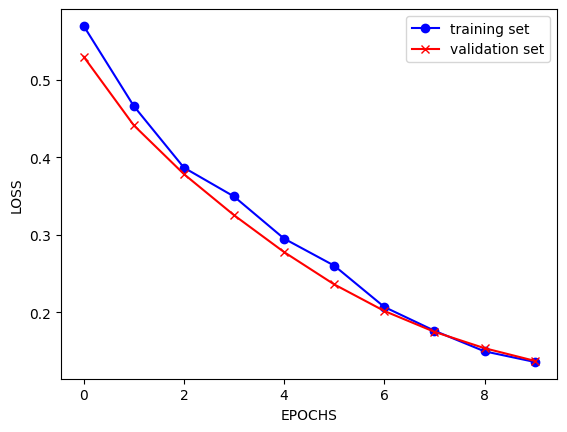

In [109]:
import matplotlib.pyplot as plt

plt.plot(x1,y_train,label="training set",color="blue",marker="o")
plt.plot(x1,y_dev,label="validation set",color="red",marker="x")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()
plt.show()